In [1]:
from __future__ import print_function
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pixyz.distributions import Normal, Bernoulli, ProductOfNormal
from pixyz.models import Model
from pixyz.losses import KullbackLeibler
from pixyz.losses import LogProb
from pixyz.losses import Expectation as E
from pixyz.losses import Parameter
from pixyz.utils import print_latex

from fmri_reconstruction_with_dmvae.mnist_svhn.dataset import getPairedDataset
from fmri_reconstruction_with_dmvae.mnist_svhn.util import unpack_data

from fmri_reconstruction_with_dmvae.mnist_svhn.classifier import MNIST_Classifier, SVHN_Classifier

seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

### Dataset

In [2]:
data_path = '../../data/mnist_svhn'

num_workers = 8
cuda = torch.cuda.is_available()

batch_size = 100

train_mnist_svhn, test_mnist_svhn = getPairedDataset(data_path, 100, cuda=cuda)
kwargs = {'num_workers': num_workers, 'pin_memory': True} if cuda else {}
train_loader = DataLoader(train_mnist_svhn, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_mnist_svhn, batch_size=batch_size, shuffle=False, **kwargs)

In [3]:
print(f"Size of train data: {len(train_mnist_svhn)}")
print(f"Size of test data: {len(test_mnist_svhn)}")

Size of train data: 1682040
Size of test data: 300000


In [4]:
# train_mnist_svhn[index][mnist(0) or svhn(1)][pixel values(0) or label(1)].shape
print(train_mnist_svhn[0][0][0].shape)  # shape of mnist pixel values
print(train_mnist_svhn[0][1][0].shape)  # shape of svhn pixel values
print(train_mnist_svhn[0][0][1])  # mnist label
print(train_mnist_svhn[0][1][1])  # svhn label

torch.Size([1, 28, 28])
torch.Size([3, 32, 32])
0
0


### Model

In [5]:
# モダリティ1: MNIST
# モダリティ2: SVHN

### Encoder
# q_φ1(zp1 | x1)
# q_φ1(zs | x1)

# q_φ2(zp2 | x2)
# q_φ2(zs | x2)

# q_φ(zs | x) = p(zs) * q_φ1(zs | x1) * q_φ2(zs | x2)

### Prior
# p(zp1)
# p(zp2)

# p(zs)

### Decoder
# p_θ1(x1 | zp1, zs)
# p_θ2(x2 | zp2, zs)

In [6]:
# q_φ1(zp1 | x1), q_φ1(zs | x1)
class InferenceX1(Normal):
    def __init__(self, var, cond_var, z_dim, x_dim=784, hidden_dim=256):
        super(InferenceX1, self).__init__(var=var, cond_var=cond_var, name="q")

        self.fc1 = nn.Linear(x_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)

    def forward(self, x1):
        h = F.relu(self.fc1(x1))
        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}

# q_φ2(zp2 | x2), q_φ2(zs | x2)
class InferenceX2(Normal):
    def __init__(self, var, cond_var, z_dim):
        super(InferenceX2, self).__init__(var=var, cond_var=cond_var, name="q")

        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc21 = nn.Linear(512, z_dim)
        self.fc22 = nn.Linear(512, z_dim)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x2):
        h = F.relu(self.conv1(x2))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))

        h = h.view(h.size(0), -1)

        h = F.relu(self.fc1(h))
        h = self.dropout(h)

        return {"loc": self.fc21(h), "scale": F.softplus(self.fc22(h))}

# p_θ1(x1 | zp1, zs)
class GeneratorX1(Bernoulli):
    def __init__(self, zp1_dim, zs_dim, x_dim=784, hidden_dim=256):
        super(GeneratorX1, self).__init__(var=["x1"], cond_var=["zp1", "zs"], name="p")

        self.fc1 = nn.Linear(zp1_dim + zs_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, x_dim)

    def forward(self, zp1, zs):
        z = torch.cat([zp1, zs], dim=1)

        h = F.relu(self.fc1(z))

        return {"probs": torch.sigmoid(self.fc2(h))}
    
# p_θ2(x2 | zp2, zs)
class GeneratorX2(Bernoulli):
    def __init__(self, zp2_dim, zs_dim):
        super(GeneratorX2, self).__init__(var=["x2"], cond_var=["zp2", "zs"], name="p")

        self.fc = nn.Linear(zp2_dim + zs_dim, 256 * 2 * 2)
        
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False)

    def forward(self, zp2, zs):
        z = torch.cat([zp2, zs], dim=1)

        h = F.relu(self.fc(z))
        
        h = h.view(-1, 256, 2, 2)

        h = F.relu(self.deconv1(h))
        h = F.relu(self.deconv2(h))
        h = F.relu(self.deconv3(h))

        return {"probs": torch.sigmoid(self.deconv4(h))}

In [7]:
zp1_dim = 1
zp2_dim = 4
zs_dim = 10

In [8]:
# q_φ1(zp1 | x1)
q_zp1__x1 = InferenceX1(var=["zp1"], cond_var=["x1"], z_dim=zp1_dim).to(device)
# q_φ1(zs1 | x1)
q_zs__x1 = InferenceX1(var=["zs"], cond_var=["x1"], z_dim=zs_dim).to(device)

# q_φ2(zp2 | x2)
q_zp2__x2 = InferenceX2(var=["zp2"], cond_var=["x2"], z_dim=zp2_dim).to(device)
# q_φ2(zs2 | x2)
q_zs__x2 = InferenceX2(var=["zs"], cond_var=["x2"], z_dim=zs_dim).to(device)

# q_φ(zs | x)
q_zs__x = ProductOfNormal([q_zs__x1, q_zs__x2], name="q").to(device)

# p(zp1)
prior_zp1 = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
               var=["zp1"], features_shape=[zp1_dim], name="p_{prior}").to(device)
# p(zp2)
prior_zp2 = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
               var=["zp2"], features_shape=[zp2_dim], name="p_{prior}").to(device)

# p(zs)
prior_zs = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
               var=["zs"], features_shape=[zs_dim], name="p_{prior}").to(device)

# p_θ1(x1 | zp1, zs)
p_x1__zp1_zs = GeneratorX1(zp1_dim=zp1_dim, zs_dim=zs_dim).to(device)
# p_θ2(x2 | zp2, zs)
p_x2__zp2_zs = GeneratorX2(zp2_dim=zp2_dim, zs_dim=zs_dim).to(device)

In [9]:
# i = 1
lambda_1 = Parameter("lambda_1")
joint_recon_loss_x1 = - lambda_1 * E(q_zp1__x1, E(q_zs__x, LogProb(p_x1__zp1_zs))) + KullbackLeibler(q_zp1__x1, prior_zp1) + KullbackLeibler(q_zs__x, prior_zs)
self_recon_loss_x1 = - lambda_1 * E(q_zp1__x1, E(q_zs__x1, LogProb(p_x1__zp1_zs))) + KullbackLeibler(q_zp1__x1, prior_zp1) + KullbackLeibler(q_zs__x1, prior_zs)
cross_recon_loss_x1 = - lambda_1 * E(q_zp1__x1, E(q_zs__x2, LogProb(p_x1__zp1_zs))) + KullbackLeibler(q_zp1__x1, prior_zp1) + KullbackLeibler(q_zs__x2, prior_zs)
loss_x1 = (joint_recon_loss_x1 + self_recon_loss_x1 + cross_recon_loss_x1).mean()

# i = 2
lambda_2 = Parameter("lambda_2")
joint_recon_loss_x2 = - lambda_2 * E(q_zp2__x2, E(q_zs__x, LogProb(p_x2__zp2_zs))) + KullbackLeibler(q_zp2__x2, prior_zp2) + KullbackLeibler(q_zs__x, prior_zs)
self_recon_loss_x2 = - lambda_2 * E(q_zp2__x2, E(q_zs__x2, LogProb(p_x2__zp2_zs))) + KullbackLeibler(q_zp2__x2, prior_zp2) + KullbackLeibler(q_zs__x2, prior_zs)
cross_recon_loss_x2 = - lambda_2 * E(q_zp2__x2, E(q_zs__x1, LogProb(p_x2__zp2_zs))) + KullbackLeibler(q_zp2__x2, prior_zp2) + KullbackLeibler(q_zs__x1, prior_zs)
loss_x2 = (joint_recon_loss_x2 + self_recon_loss_x2 + cross_recon_loss_x2).mean()

loss = loss_x1 + loss_x2    

In [10]:
model = Model(loss=loss, distributions=[q_zp1__x1, q_zs__x1, q_zp2__x2, q_zs__x2, q_zs__x, p_x1__zp1_zs, p_x2__zp2_zs], optimizer=optim.Adam, optimizer_params={"lr": 1e-3})

### Training

In [11]:
def train(epoch):
    train_loss = 0
    for data in tqdm(train_loader):
        unpacked_data = unpack_data(data, device)
        x1 = unpacked_data[0].to(device)
        x2 = unpacked_data[1].to(device)
        x1 = x1.view(-1, 784)

        loss = model.train({"x1": x1, "x2": x2, "lambda_1": 50.0, "lambda_2": 1.0})
        train_loss += loss
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [12]:
def test(epoch):
    test_loss = 0
    with torch.no_grad():
        for data in tqdm(test_loader):
            unpacked_data = unpack_data(data, device)
            x1 = unpacked_data[0].to(device)
            x2 = unpacked_data[1].to(device)
            x1 = x1.view(-1, 784)

            loss = model.test({"x1": x1, "x2": x2, "lambda_1": 50.0, "lambda_2": 1.0})
            test_loss += loss
    test_loss = test_loss * test_loader.batch_size / len(test_loader.dataset)
    print('Epoch: {} Test loss: {:.4f}'.format(epoch, test_loss))
    return test_loss

In [13]:
epochs = 7

In [14]:
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)

100%|██████████| 16821/16821 [28:16<00:00,  9.92it/s]


Epoch: 1 Train loss: 22840.8555


100%|██████████| 3000/3000 [01:23<00:00, 35.75it/s]


Epoch: 1 Test loss: 22052.5059


100%|██████████| 16821/16821 [26:36<00:00, 10.54it/s]


Epoch: 2 Train loss: 21617.4141


100%|██████████| 3000/3000 [01:22<00:00, 36.21it/s]


Epoch: 2 Test loss: 21891.8906


100%|██████████| 16821/16821 [28:42<00:00,  9.77it/s]


Epoch: 3 Train loss: 21397.7754


100%|██████████| 3000/3000 [01:18<00:00, 38.07it/s]


Epoch: 3 Test loss: 21824.8594


100%|██████████| 16821/16821 [29:13<00:00,  9.59it/s]


Epoch: 4 Train loss: 21287.8340


100%|██████████| 3000/3000 [01:24<00:00, 35.53it/s]


Epoch: 4 Test loss: 21817.8691


100%|██████████| 16821/16821 [28:34<00:00,  9.81it/s]


Epoch: 5 Train loss: 21219.4004


100%|██████████| 3000/3000 [01:26<00:00, 34.62it/s]


Epoch: 5 Test loss: 21825.5215


100%|██████████| 16821/16821 [25:59<00:00, 10.78it/s]


Epoch: 6 Train loss: 21172.1484


100%|██████████| 3000/3000 [01:21<00:00, 36.59it/s]


Epoch: 6 Test loss: 21838.1465


100%|██████████| 16821/16821 [28:21<00:00,  9.89it/s]


Epoch: 7 Train loss: 21136.8906


100%|██████████| 3000/3000 [01:26<00:00, 34.58it/s]

Epoch: 7 Test loss: 21884.9551


In [15]:
model.save("../../checkpoints/mnist_svhn/baseline_model.pt")

### Validation

In [16]:
model.load("../../checkpoints/mnist_svhn/baseline_model.pt")

#### Reconstruction

In [17]:
_data = next(iter(test_loader))

_unpacked_data = unpack_data(_data, device)
_x1 = _unpacked_data[0].to(device)
_x2 = _unpacked_data[1].to(device)

In [18]:
with torch.no_grad():
    _zp1 = q_zp1__x1.sample({"x1": _x1.view(-1, 784)}, return_all=False)
    _zp2 = q_zp2__x2.sample({"x2": _x2}, return_all=False)

    _zs__x = q_zs__x.sample({"x1": _x1.view(-1, 784), "x2": _x2}, return_all=False)

    _zs__x1 = q_zs__x1.sample({"x1": _x1.view(-1, 784)}, return_all=False)
    _zs__x2 = q_zs__x2.sample({"x2": _x2}, return_all=False)

    joint_recon_x1 = p_x1__zp1_zs.sample_mean(_zp1 | _zs__x).view(-1, 1, 28, 28).cpu()
    joint_recon_x2 = p_x2__zp2_zs.sample_mean(_zp2 | _zs__x).cpu()

    self_recon_x1 = p_x1__zp1_zs.sample_mean(_zp1 | _zs__x1).view(-1, 1, 28, 28).cpu()
    self_recon_x2 = p_x2__zp2_zs.sample_mean(_zp2 | _zs__x2).cpu()

    cross_recon_x1 = p_x1__zp1_zs.sample_mean(_zp1 | _zs__x2).view(-1, 1, 28, 28).cpu()
    cross_recon_x2 = p_x2__zp2_zs.sample_mean(_zp2 | _zs__x1).cpu()

In [19]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

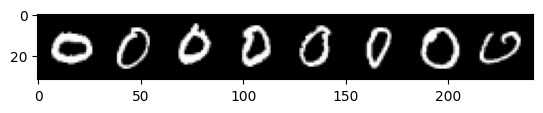

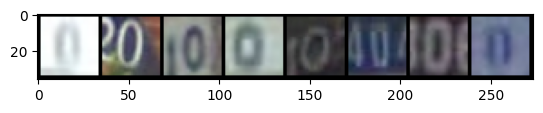

In [20]:
imshow(torchvision.utils.make_grid(_x1.view(-1, 1, 28, 28)[:8].cpu()))
imshow(torchvision.utils.make_grid(_x2[:8].cpu()))

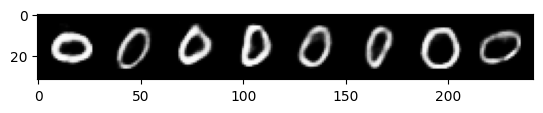

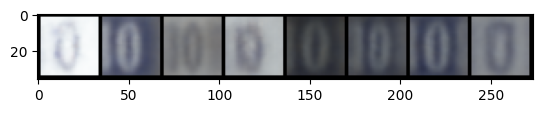

In [21]:
imshow(torchvision.utils.make_grid(joint_recon_x1[:8]))
imshow(torchvision.utils.make_grid(joint_recon_x2[:8]))

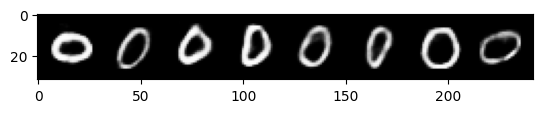

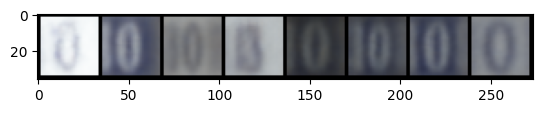

In [22]:
imshow(torchvision.utils.make_grid(self_recon_x1[:8]))
imshow(torchvision.utils.make_grid(self_recon_x2[:8]))

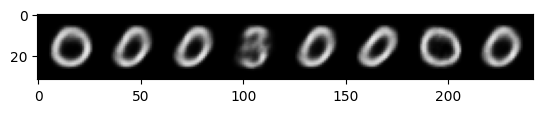

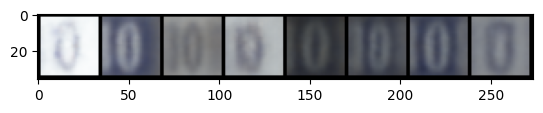

In [23]:
imshow(torchvision.utils.make_grid(cross_recon_x1[:8]))
imshow(torchvision.utils.make_grid(cross_recon_x2[:8]))

#### Classification

In [24]:
mnist_classifier = MNIST_Classifier().to(device)
svhn_classifier = SVHN_Classifier().to(device)

mnist_classifier.load_state_dict(torch.load("../../checkpoints/mnist_svhn/mnist_classifier.pt"))
svhn_classifier.load_state_dict(torch.load("../../checkpoints/mnist_svhn/svhn_classifier.pt"))
# mnist_classifier.load_state_dict(torch.load("../../checkpoints/mnist_svhn/mnist_classifier.pt", map_location=device))
# svhn_classifier.load_state_dict(torch.load("../../checkpoints/mnist_svhn/svhn_classifier.pt", map_location=device))

mnist_classifier.eval()
svhn_classifier.eval()

SVHN_Classifier(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [25]:
acc_mnist = 0
acc_svhn = 0

joint_recon_acc_mnist = 0
joint_recon_acc_svhn = 0

self_recon_acc_mnist = 0
self_recon_acc_svhn = 0

cross_recon_acc_mnist = 0
cross_recon_acc_svhn = 0

prior_recon_acc_joint = 0

for data in tqdm(test_loader):
    unpacked_data = unpack_data(data, device)

    # original data
    x1 = unpacked_data[0].to(device)
    x2 = unpacked_data[1].to(device)

    with torch.no_grad():
        # sampling
        zp1 = q_zp1__x1.sample({"x1": x1.view(-1, 784)}, return_all=False)
        zp2 = q_zp2__x2.sample({"x2": x2}, return_all=False)

        zs__x = q_zs__x.sample({"x1": x1.view(-1, 784), "x2": x2}, return_all=False)

        zs__x1 = q_zs__x1.sample({"x1": x1.view(-1, 784)}, return_all=False)
        zs__x2 = q_zs__x2.sample({"x2": x2}, return_all=False)

        zs__prior = prior_zs.sample(batch_n=test_loader.batch_size, return_all=False)

        # joint recon 
        joint_recon_x1 = p_x1__zp1_zs.sample_mean(zp1 | zs__x).view(-1, 1, 28, 28)
        joint_recon_x2 = p_x2__zp2_zs.sample_mean(zp2 | zs__x)

        # self recon
        self_recon_x1 = p_x1__zp1_zs.sample_mean(zp1 | zs__x1).view(-1, 1, 28, 28)
        self_recon_x2 = p_x2__zp2_zs.sample_mean(zp2 | zs__x2)

        # cross recon 
        cross_recon_x1 = p_x1__zp1_zs.sample_mean(zp1 | zs__x2).view(-1, 1, 28, 28)
        cross_recon_x2 = p_x2__zp2_zs.sample_mean(zp2 | zs__x1)

        # prior recon
        prior_recon_x1 = p_x1__zp1_zs.sample_mean(zp1 | zs__prior).view(-1, 1, 28, 28)
        prior_recon_x2 = p_x2__zp2_zs.sample_mean(zp2 | zs__prior)

    # prediction
    x1_label = data[0][1].cpu().numpy()
    x2_label = data[1][1].cpu().numpy()

    x1_pred = torch.argmax(mnist_classifier(x1), dim=1).cpu().detach().numpy()
    x2_pred = torch.argmax(svhn_classifier(x2), dim=1).cpu().detach().numpy()

    joint_recon_x1_pred = torch.argmax(mnist_classifier(joint_recon_x1), dim=1).cpu().detach().numpy()
    joint_recon_x2_pred = torch.argmax(svhn_classifier(joint_recon_x2), dim=1).cpu().detach().numpy()

    self_recon_x1_pred = torch.argmax(mnist_classifier(self_recon_x1), dim=1).cpu().detach().numpy()
    self_recon_x2_pred = torch.argmax(svhn_classifier(self_recon_x2), dim=1).cpu().detach().numpy()

    cross_recon_x1_pred = torch.argmax(mnist_classifier(cross_recon_x1), dim=1).cpu().detach().numpy()
    cross_recon_x2_pred = torch.argmax(svhn_classifier(cross_recon_x2), dim=1).cpu().detach().numpy()

    prior_recon_x1 = torch.argmax(mnist_classifier(prior_recon_x1), dim=1).cpu().detach().numpy()
    prior_recon_x2 = torch.argmax(svhn_classifier(prior_recon_x2), dim=1).cpu().detach().numpy()

    # calculate accuracy
    acc_mnist += (x1_label == x1_pred).sum() / len(test_loader.dataset)
    acc_svhn += (x2_label == x2_pred).sum() / len(test_loader.dataset)

    # acc A from poe
    joint_recon_acc_mnist += (x1_label == joint_recon_x1_pred).sum() / len(test_loader.dataset)
    # acc B from poe
    joint_recon_acc_svhn += (x2_label == joint_recon_x2_pred).sum() / len(test_loader.dataset)

    # acc A
    self_recon_acc_mnist += (x1_label == self_recon_x1_pred).sum() / len(test_loader.dataset)
    # acc B
    self_recon_acc_svhn += (x2_label == self_recon_x2_pred).sum() / len(test_loader.dataset)

    # acc A from B
    cross_recon_acc_mnist += (x1_label == cross_recon_x1_pred).sum() / len(test_loader.dataset)
    # acc B from A
    cross_recon_acc_svhn += (x2_label == cross_recon_x2_pred).sum() / len(test_loader.dataset)

    # acc joint
    prior_recon_acc_joint += ((prior_recon_x1 == prior_recon_x2)).sum() / len(test_loader.dataset)

print('------Reported results------')
print('acc A from B:', np.round(cross_recon_acc_mnist, 4))
print('acc B from A:', np.round(cross_recon_acc_svhn, 4))
print('joint:', np.round(prior_recon_acc_joint, 4))

print('------own generated acc ------')
print('acc A:', np.round(self_recon_acc_mnist, 4))
print('acc B:', np.round(self_recon_acc_svhn, 4))

print('------poe------')
print('acc A from poe:', np.round(joint_recon_acc_mnist, 4))
print('acc B from poe:', np.round(joint_recon_acc_svhn, 4))

print('------original data------')
print('acc original A:', np.round(acc_mnist, 4))
print('acc original B:', np.round(acc_svhn, 4))

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:50<00:00, 59.43it/s]

------Reported results------
acc A from B: 0.855
acc B from A: 0.8941
joint: 0.4104
------own generated acc ------
acc A: 0.9531
acc B: 0.8182
------poe------
acc A from poe: 0.9547
acc B from poe: 0.8968
------original data------
acc original A: 0.9924
acc original B: 0.8812
